In [2]:
from spectrumtools.spectrum import Spectrum, Source
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [5]:
a = Spectrum("data/fake_data.csv")
s1 = Source(3000, [605.4, 1392.42], [0.333, 0.666])
s2 = Source(2000, [1210.8], [1.0])
print(a.calibrate((s1,s2)))
#print(a.find_peaks())
a.show_histogram("a")

Energy(c) = 0.0c^2 + 0.5987c + 5.251
[2.02272644e-06 5.98729048e-01 5.25099783e+00]


In [177]:

# Lab0.h5
# Source: Cs-137

# invert pulses false, 500 trigger delay, 170 trigger threshold
f_name = '../data/co60.h5'
f_data = h5py.File(f_name,'r')
raw_data0 = f_data['raw_data'][()]

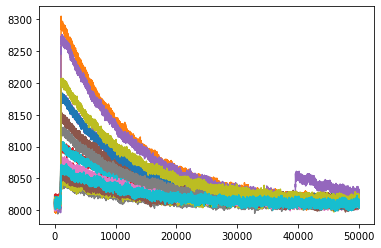

In [178]:
# plot all pulses
# last week
plt.figure()
for i in range(20,40):#len(raw_data0)):
    plt.plot(raw_data0[i])
plt.show()

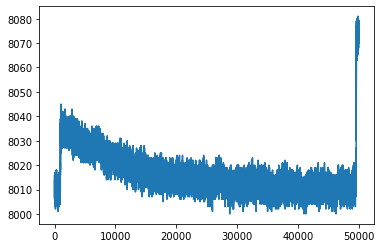

In [161]:
def exponential(t, a, tau, c):
    return a * np.exp(-t / tau) + c

def find_amplitude(waveform, width=30):
    # Calculate the baseline value by averaging the first 20 data points
    waveform = np.int64(waveform)
    #baseline_value = np.convolve(waveform[0:width], np.ones(width), 'valid') / width
    
    # Make a smooth version of the c
    #waveform = np.convolve(waveform, np.ones(width), 'valid') / width
    max_location = np.argmax(waveform)
    n = np.arange(0, len(waveform))
    '''
    # Determine Tau
    
    decay_indices = n[max_location:-1]
    decay_indices_norm = (decay_indices - decay_indices[0])/(decay_indices[-1] - decay_indices[0])
    c_0 = waveform[-1]
    tau_0 = 1
    a_0 = (waveform[0] - waveform[-1])
    popt, pcov = curve_fit(exponential, decay_indices_norm, waveform[decay_indices], p0=(a_0, tau_0, c_0))
    a, tau, c = popt
    tau *= max(n)
    '''
    
    start_time = 950
    #print(max_location)
    #k = max_location-start_time
    k= 100
    l = 300
    tau = 11000
    
    #print(tau)
    sample_length = 2000
    test = trapezoid_impulse(np.arange(0,max(n)-(k+l)), tau, k, l)
    decay = waveform[range(max_location,max_location+sample_length)]
    filtered = np.convolve(decay,test)[:sample_length]
    
    s = np.zeros(len(waveform))
    d_kl = np.zeros(len(waveform))
    '''
    for i in range(max_location, max_location+k+l):
        j = i+k+l

        d_kl[i] = waveform[j]-waveform[j-k]-waveform[j-l]+waveform[j-k-l]
        #print(d_kl)
        s[i] = s[i-1]*(1+1/tau) + d_kl[i]
    '''
    
    '''
    print(s)
    
    plt.figure()
    #plt.plot(waveform, label="Raw waveform")
    plt.plot(filtered, label="Trapezoid")
    #plt.plot(decay_indices, exponential(decay_indices_norm, a, tau/max(n), c), label="tau: {0}".format(tau))
    plt.xlim(0,1400)
    #plt.ylim(1,1000000)
    plt.legend()
    plt.show()
    '''
    return max(filtered)


#plt.plot(raw_data0[1116])
# plot single pulse
#find_amplitude(raw_data0[1116])

In [179]:
pulse_heights = np.zeros(len(raw_data0))
for i in range(len(raw_data0)):
    try: 
        pulse_heights[i] = find_amplitude(raw_data0[i])
    except:
        pulse_heights[i] = pulse_heights[i-1]


5396


C:\Users\ianko\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys


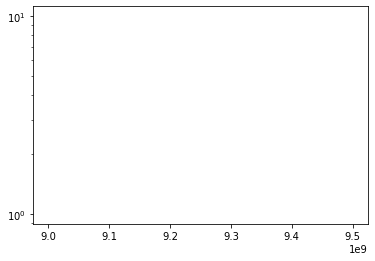

In [203]:
print(len(raw_data0))
#counts, bins = np.histogram(pulse_heights,bins=2000)
#print(bins[0:10])
counts, bins = np.histogram(pulse_heights,bins=200, range=[9.0e+09, 9.5e+9])

plt.hist(bins[:-1], bins, weights=counts)
plt.yscale('log')
plt.show()

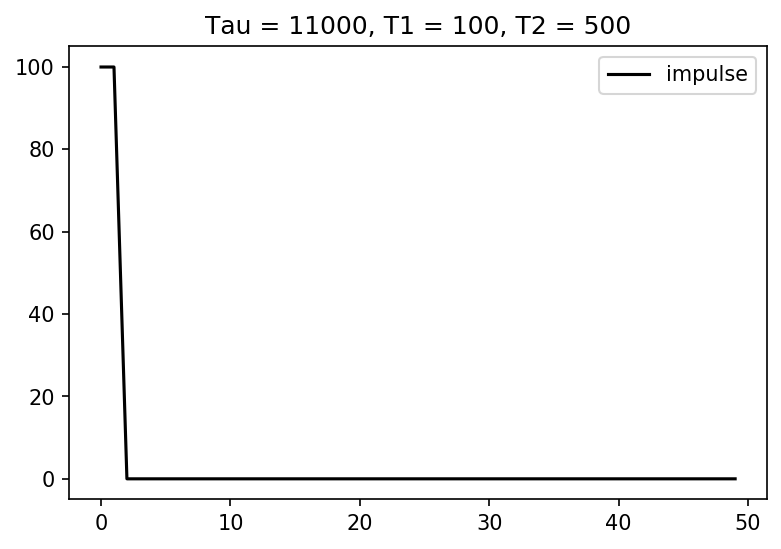

In [175]:
def trapezoid_impulse(t, tau, T1, T2):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, T1), T2), np.roll(moving_average(t, T2), T1)
    h = h1 + tau*h2 + (T1-tau)*h2_t_T1 - h1_t_T2
    return h

ln = 1000
t = np.linspace(0, 45000)

test_exp = np.exp(-t/11000)
test_exp2 = 1.5*np.exp(-t/11000)
test_exp3 = 2*np.exp(-t/11000)

tau, T1, T2 = 11000, 100, 500
test = trapezoid_impulse(t, tau, T1, T2)

fig = plt.figure(dpi=150)
plt.plot(test, color='black', label='impulse')
plt.title('Tau = {}, T1 = {}, T2 = {}'.format(tau, T1, T2))
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.plot(test_exp, c='red', label='signal 1')
#ax1.plot(test_exp2, c='green', label='signal 2')
#ax1.plot(test_exp3, c='blue', label='signal 3')
ax1.legend()

ax2.plot(np.convolve(test_exp, test)[:ln], c='red', label='convolution 1')
#ax2.plot(np.convolve(test_exp2, test)[:ln], c='green', label='convolution 2')
#ax2.plot(np.convolve(test_exp3, test)[:ln], c='blue', label='convolution 3')
ax2.legend()
plt.tight_layout()
plt.show()

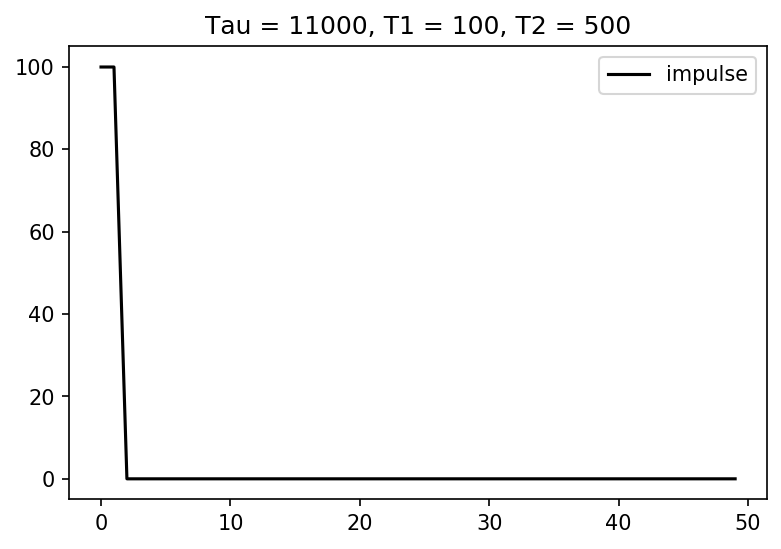

In [180]:
def trapezoid_impulse(t, tau, T1, T2):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, T1), T2), np.roll(moving_average(t, T2), T1)
    h = h1 + tau*h2 + (T1-tau)*h2_t_T1 - h1_t_T2
    return h

def truncated_ramp(t, k): 
    return np.concatenate((t[:np.argmin(np.abs(t-k))+1], 
            np.zeros(len(t)-np.argmin(np.abs(t-k))-1)))

def moving_average(t, l):
    return np.concatenate((np.ones(np.argmin(np.abs(t-l))+1), 
            np.zeros(len(t)-np.argmin(np.abs(t-l))-1)))

def generate_trapezoid_filter(t, tau, k, l):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, k), l), np.roll(moving_average(t, l), k)
    h = h1 + tau*h2 + (k-tau)*h2_t_T1 - h1_t_T2
    return h

ln = 1000
t = np.linspace(0, 45000)

test_exp = np.exp(-t/11000)
test_exp2 = 1.5*np.exp(-t/11000)
test_exp3 = 2*np.exp(-t/11000)

tau, T1, T2 = 11000, 100, 500
test = trapezoid_impulse(t, tau, T1, T2)

fig = plt.figure(dpi=150)
plt.plot(test, color='black', label='impulse')
plt.title('Tau = {}, T1 = {}, T2 = {}'.format(tau, T1, T2))
plt.legend()
plt.show()


In [113]:
list = np.arange(100)
list[0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])